# Analyse de réseaux


* [Théorie (mathématique) des graphes](https://fr.wikipedia.org/wiki/Th%C3%A9orie_des_graphes) (Wikipedia)
* [Analyse des réseaux sociaux](https://fr.wikipedia.org/wiki/Analyse_des_r%C3%A9seaux_sociaux) (Wikipedia)
* Jacques Cellier / Martine Cocaud, _Le traitement des données en histoire et sciences sociales : méthodes et outils_, Rennes: Presses univ. de Rennes, 2012. 
  * Partie IV, Chapitres 11-15 : "Analyse des réseaux sociaux"
  * [Site du livre mettant à disposition les données utilisées](http://jacquescellier.fr/histoire/site_tdh2/)
* Wouter de Nooy / Andrej Mrvar / Vladimir Batagelj, _Exploratory Social Network Analysis with Pajek_, Third edition, Cambridge: Cambridge University Press, 2018.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# https://networkx.org/documentation/stable/install.html
import networkx as nx

#https://ipycytoscape.readthedocs.io/en/latest/installing.html
import ipycytoscape as cy

In [3]:
import pprint
import csv
import ast
import re

from collections import Counter, defaultdict
from operator import itemgetter
import itertools

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

import math

## Définitions

* Un graphe est un ensemble de sommets ou noeuds (_vertices_ ou _nodes_) reliés par des relations
* Si les relations sont symétriques (par ex., la personne A discute avec la personne B) le graphe est non orienté (_undirected_), sinon le graphe est dit orienté (_directed_) (par ex., A préfère B parmi ses amies)
* Dans le cas d'un graphe orienté, les relations sont des fléches ou arcs (_arrow_ ou _arc_), sinon on parle de arêtes (_edges_)

## Ouvrir et explorer un graphe existant

In [7]:
### Ouvrir un document un graphe au format Pajek
# https://networkx.org/documentation/stable/reference/readwrite/generated/networkx.readwrite.pajek.read_pajek.html

## inspecter préalablement le fichier dans un éditeur de texte : edges = undirected

# cette fonction ne dispose pas de paramètre en entrée, sauf le fichier au format Pajek

PK = nx.read_pajek('data/cellier_cocaud_chap_11-15/florence.net')


In [8]:
### Le résultat de la fonction est un MultiGraph 
# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/multigraph.html

print(type(PK))

# Propriétés essentielles du graphe
print(nx.info(PK))

<class 'networkx.classes.multigraph.MultiGraph'>
Name: 
Type: MultiGraph
Number of nodes: 15
Number of edges: 20
Average degree:   2.6667


In [9]:
## Inspecter le graphe (s'il est suffisamment petit !)
print(PK.nodes.data())
print('-----')
print(PK.edges.data())

[('ACCIAIUOLI', {'id': '1'}), ('ALBIZZI', {'id': '2'}), ('BARBADORI', {'id': '3'}), ('BISCHERI', {'id': '4'}), ('CASTELLANI', {'id': '5'}), ('GINORI', {'id': '6'}), ('GUADAGNI', {'id': '7'}), ('LAMBERTESCHI', {'id': '8'}), ('MEDICI', {'id': '9'}), ('PAZZI', {'id': '10'}), ('PERUZZI', {'id': '11'}), ('RIDOLFI', {'id': '12'}), ('SALVIATI', {'id': '13'}), ('STROZZI', {'id': '14'}), ('TORNABUONI', {'id': '15'})]
-----
[('ACCIAIUOLI', 'MEDICI', {}), ('ALBIZZI', 'GINORI', {}), ('ALBIZZI', 'GUADAGNI', {}), ('ALBIZZI', 'MEDICI', {}), ('BARBADORI', 'CASTELLANI', {}), ('BARBADORI', 'MEDICI', {}), ('BISCHERI', 'GUADAGNI', {}), ('BISCHERI', 'PERUZZI', {}), ('BISCHERI', 'STROZZI', {}), ('CASTELLANI', 'PERUZZI', {}), ('CASTELLANI', 'STROZZI', {}), ('GUADAGNI', 'LAMBERTESCHI', {}), ('GUADAGNI', 'TORNABUONI', {}), ('MEDICI', 'RIDOLFI', {}), ('MEDICI', 'SALVIATI', {}), ('MEDICI', 'TORNABUONI', {}), ('PAZZI', 'SALVIATI', {}), ('PERUZZI', 'STROZZI', {}), ('RIDOLFI', 'STROZZI', {}), ('RIDOLFI', 'TORNABUON

In [10]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

PK.is_multigraph(), PK.is_directed(), PK.number_of_nodes(), PK.number_of_edges(), nx.is_connected(PK), nx.density(PK)

(True, False, 15, 20, True, 0.19047619047619047)

In [11]:
### Y a-t-il des loops ? Un sommet en relation avec lui même ?
# https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.nodes_with_selfloops.html
list(nx.nodes_with_selfloops(PK))

[]

### Nettoyer le graphe original (format Pajek .net)

In [12]:
### Create an undirected graph of your multigraph where multiple edges are merged into single edges
# https://stackoverflow.com/questions/15590812/networkx-convert-multigraph-into-simple-graph-with-weighted-edges
G = nx.Graph(PK)
print(type(G))
print(nx.info(G))

<class 'networkx.classes.graph.Graph'>
Name: 
Type: Graph
Number of nodes: 15
Number of edges: 20
Average degree:   2.6667


In [13]:
### Eliminer les 'id' du format .net de Pajek (qui risquent de dérnager)
# et transformer en graphe simple (agréger les lignes multiples)

# liste des noeuds ou sommets
e = G.nodes()
pop = [G.nodes[n].pop('id',None) for n in e]

In [14]:
## Inspecter le résultat, les attributs ou propriétés 'id' ont disparu
# Noter que les noms font fonction d'identifiant
print(G.nodes.data())
print('-----')
print(G.edges.data())

[('ACCIAIUOLI', {}), ('ALBIZZI', {}), ('BARBADORI', {}), ('BISCHERI', {}), ('CASTELLANI', {}), ('GINORI', {}), ('GUADAGNI', {}), ('LAMBERTESCHI', {}), ('MEDICI', {}), ('PAZZI', {}), ('PERUZZI', {}), ('RIDOLFI', {}), ('SALVIATI', {}), ('STROZZI', {}), ('TORNABUONI', {})]
-----
[('ACCIAIUOLI', 'MEDICI', {}), ('ALBIZZI', 'GINORI', {}), ('ALBIZZI', 'GUADAGNI', {}), ('ALBIZZI', 'MEDICI', {}), ('BARBADORI', 'CASTELLANI', {}), ('BARBADORI', 'MEDICI', {}), ('BISCHERI', 'GUADAGNI', {}), ('BISCHERI', 'PERUZZI', {}), ('BISCHERI', 'STROZZI', {}), ('CASTELLANI', 'PERUZZI', {}), ('CASTELLANI', 'STROZZI', {}), ('GUADAGNI', 'LAMBERTESCHI', {}), ('GUADAGNI', 'TORNABUONI', {}), ('MEDICI', 'RIDOLFI', {}), ('MEDICI', 'SALVIATI', {}), ('MEDICI', 'TORNABUONI', {}), ('PAZZI', 'SALVIATI', {}), ('PERUZZI', 'STROZZI', {}), ('RIDOLFI', 'STROZZI', {}), ('RIDOLFI', 'TORNABUONI', {})]


In [15]:
### En analyse de réseaux on travaille avec des matrices: 
#  transformer en matrice — au format DataFrame Pandas
#  https://networkx.org/documentation/stable/reference/convert.html

## Modifier l'affichage des décimaux,le formatage, pour ne voir que les entiers
pd.options.display.float_format = '{: .0f}'.format

nx.to_pandas_adjacency(G)

,ACCIAIUOLI,ALBIZZI,BARBADORI,BISCHERI,CASTELLANI,GINORI,GUADAGNI,LAMBERTESCHI,MEDICI,PAZZI,PERUZZI,RIDOLFI,SALVIATI,STROZZI,TORNABUONI
ACCIAIUOLI,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
ALBIZZI,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
BARBADORI,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
BISCHERI,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
CASTELLANI,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
GINORI,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
GUADAGNI,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1
LAMBERTESCHI,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
MEDICI,1,1,1,0,0,0,0,0,0,0,0,1,1,0,1
PAZZI,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


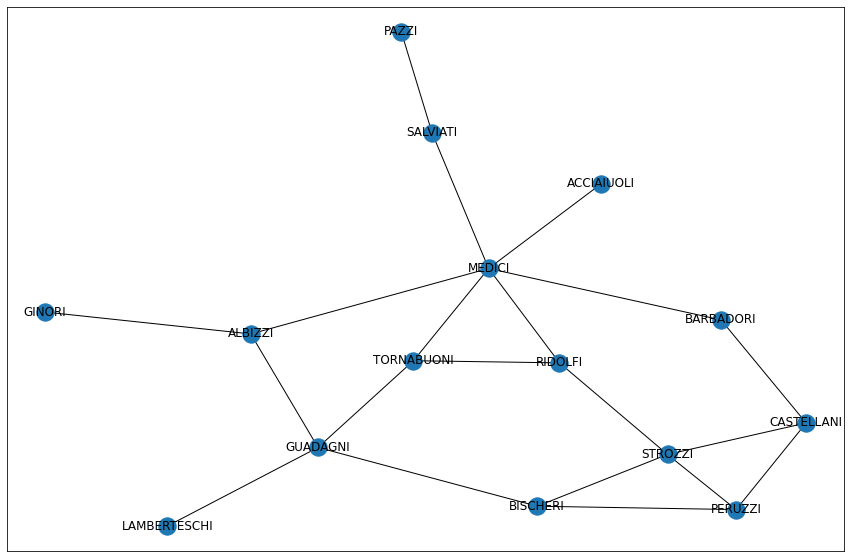

In [16]:
### Un premier affichage (ne marche que avec peu de sommets)

# l'algorithme cherche la meilleure position des somments
# si on exécute plurieurs fois l'apparence peut changer

plt.figure(figsize = (15,10))
nx.draw_networkx(G)

### Modifier le _layout_ pour l'affichage

{'ACCIAIUOLI': array([ 0.73000099, -0.15172046]), 'ALBIZZI': array([0.32635541, 0.35420492]), 'BARBADORI': array([-0.12373774, -0.54447252]), 'BISCHERI': array([-0.63582217,  0.37024008]), 'CASTELLANI': array([-0.63036667, -0.46444856]), 'GINORI': array([0.67651231, 0.65612304]), 'GUADAGNI': array([-0.15407429,  0.55065159]), 'LAMBERTESCHI': array([-0.22197702,  1.        ]), 'MEDICI': array([ 0.27286024, -0.18385882]), 'PAZZI': array([ 0.7994185 , -0.93238171]), 'PERUZZI': array([-0.90044025, -0.0363949 ]), 'RIDOLFI': array([-0.13787791, -0.1369888 ]), 'SALVIATI': array([ 0.52270309, -0.5877544 ]), 'STROZZI': array([-0.57227185, -0.06773618]), 'TORNABUONI': array([0.04871735, 0.17453673])}


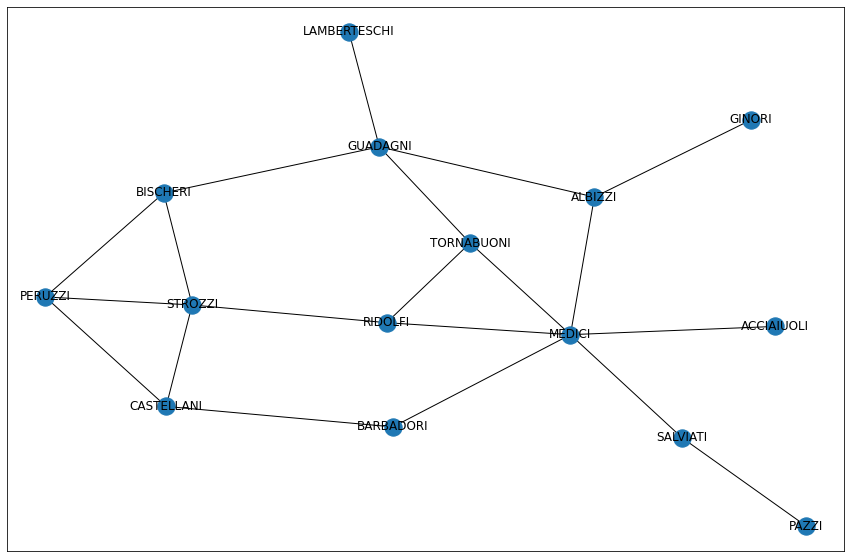

In [17]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)
print(pos)

nx.draw_networkx(G, pos)

### Enregistrer l'image

In [18]:
# Enregistrer un export jpg
plt.savefig("graphs/G_draw_networkx.jpg", format="jpg")

<Figure size 432x288 with 0 Axes>

## Ajouter des attributs aux sommets

In [19]:
### Créer un DataFrame contenant le fichier CSV mis à disposition, 
#  contenant les attributs ou propriétés des sommets 
#  Attention à indiquer que la colonne 'id' doit être l'index du DataFrame
attributes = pd.read_csv('data/cellier_cocaud_chap_11-15/florencesarttributs.csv', sep= ';', index_col= 'id')
attributes

,Parti,Revenus,Sieges
id,,,
ACCIAIUOLI,MED,10,53
ALBIZZI,OLI,36,65
BARBADORI,GIR,55,0
BISCHERI,OLI,44,12
CASTELLANI,OLI,20,22
GINORI,MED,32,0
GUADAGNI,OLI,8,21
LAMBERTESCHI,OLI,42,0
MEDICI,MED,103,53


In [20]:
### Avant d'ajouter les attributs au graphe, 
#  créer un dictionnaire ayant pour clé l'index du DataFrame

#  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_dict.html
dict_attr = attributes.to_dict('index')
print(dict_attr)

{'ACCIAIUOLI': {'Parti': 'MED', 'Revenus': 10, 'Sieges': 53}, 'ALBIZZI': {'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65}, 'BARBADORI': {'Parti': 'GIR', 'Revenus': 55, 'Sieges': 0}, 'BISCHERI': {'Parti': 'OLI', 'Revenus': 44, 'Sieges': 12}, 'CASTELLANI': {'Parti': 'OLI', 'Revenus': 20, 'Sieges': 22}, 'GINORI': {'Parti': 'MED', 'Revenus': 32, 'Sieges': 0}, 'GUADAGNI': {'Parti': 'OLI', 'Revenus': 8, 'Sieges': 21}, 'LAMBERTESCHI': {'Parti': 'OLI', 'Revenus': 42, 'Sieges': 0}, 'MEDICI': {'Parti': 'MED', 'Revenus': 103, 'Sieges': 53}, 'PAZZI': {'Parti': 'GIR', 'Revenus': 48, 'Sieges': 0}, 'PERUZZI': {'Parti': 'OLI', 'Revenus': 49, 'Sieges': 42}, 'RIDOLFI': {'Parti': 'MED', 'Revenus': 27, 'Sieges': 38}, 'SALVIATI': {'Parti': 'MED', 'Revenus': 10, 'Sieges': 35}, 'STROZZI': {'Parti': 'OLI', 'Revenus': 146, 'Sieges': 74}, 'TORNABUONI': {'Parti': 'MED', 'Revenus': 48, 'Sieges': 0}}


In [21]:
###  Ajouter les attributs
#  La clé de jointure est l'id du dictionnaire premier niveau – l'id du sommet:
#  Il s'agit donc du nom majuscule dans ce cas
#  https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_node_attributes.html

nx.set_node_attributes(G, dict_attr)

# inspecter les sommets et leurs attributs
list(G.nodes.data())

[('ACCIAIUOLI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 53}),
 ('ALBIZZI', {'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65}),
 ('BARBADORI', {'Parti': 'GIR', 'Revenus': 55, 'Sieges': 0}),
 ('BISCHERI', {'Parti': 'OLI', 'Revenus': 44, 'Sieges': 12}),
 ('CASTELLANI', {'Parti': 'OLI', 'Revenus': 20, 'Sieges': 22}),
 ('GINORI', {'Parti': 'MED', 'Revenus': 32, 'Sieges': 0}),
 ('GUADAGNI', {'Parti': 'OLI', 'Revenus': 8, 'Sieges': 21}),
 ('LAMBERTESCHI', {'Parti': 'OLI', 'Revenus': 42, 'Sieges': 0}),
 ('MEDICI', {'Parti': 'MED', 'Revenus': 103, 'Sieges': 53}),
 ('PAZZI', {'Parti': 'GIR', 'Revenus': 48, 'Sieges': 0}),
 ('PERUZZI', {'Parti': 'OLI', 'Revenus': 49, 'Sieges': 42}),
 ('RIDOLFI', {'Parti': 'MED', 'Revenus': 27, 'Sieges': 38}),
 ('SALVIATI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 35}),
 ('STROZZI', {'Parti': 'OLI', 'Revenus': 146, 'Sieges': 74}),
 ('TORNABUONI', {'Parti': 'MED', 'Revenus': 48, 'Sieges': 0})]

### Afficher en fonction des attributs

In [22]:
### Adapter la taille des attribut à l'affichage
node_sizes = [i[1]['Revenus'] * 5 for i in list(G.nodes.data())]
node_sizes

[50, 180, 275, 220, 100, 160, 40, 210, 515, 240, 245, 135, 50, 730, 240]

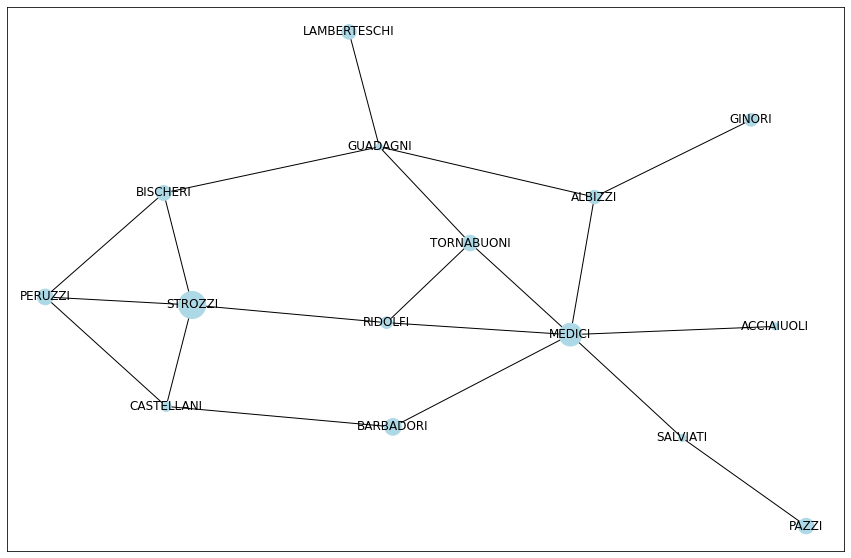

In [23]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, pos, node_size=node_sizes, node_color='LightBlue')

## Une nouvelle information : les familles les plus riches se trouvent au centre du réseau
#  Ce n'est pas nécessairement le cas

## Ajouter les paramètres de centralité

Noter que les fonctions produisent des résultats avec des formats différents, qu'il s'agira de traiter

### Centralité de degré

In [24]:
print(nx.degree(G))
print('----')
### l'ajout d'une propriété doit se faire sous la forme de dictionnaire
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(G)])
print(degree)

[('ACCIAIUOLI', 1), ('ALBIZZI', 3), ('BARBADORI', 2), ('BISCHERI', 3), ('CASTELLANI', 3), ('GINORI', 1), ('GUADAGNI', 4), ('LAMBERTESCHI', 1), ('MEDICI', 6), ('PAZZI', 1), ('PERUZZI', 3), ('RIDOLFI', 3), ('SALVIATI', 2), ('STROZZI', 4), ('TORNABUONI', 3)]
----
{'ACCIAIUOLI': {'degree': 1}, 'ALBIZZI': {'degree': 3}, 'BARBADORI': {'degree': 2}, 'BISCHERI': {'degree': 3}, 'CASTELLANI': {'degree': 3}, 'GINORI': {'degree': 1}, 'GUADAGNI': {'degree': 4}, 'LAMBERTESCHI': {'degree': 1}, 'MEDICI': {'degree': 6}, 'PAZZI': {'degree': 1}, 'PERUZZI': {'degree': 3}, 'RIDOLFI': {'degree': 3}, 'SALVIATI': {'degree': 2}, 'STROZZI': {'degree': 4}, 'TORNABUONI': {'degree': 3}}


In [25]:
nx.set_node_attributes(G, degree)
print(G.nodes.data())

[('ACCIAIUOLI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 53, 'degree': 1}), ('ALBIZZI', {'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65, 'degree': 3}), ('BARBADORI', {'Parti': 'GIR', 'Revenus': 55, 'Sieges': 0, 'degree': 2}), ('BISCHERI', {'Parti': 'OLI', 'Revenus': 44, 'Sieges': 12, 'degree': 3}), ('CASTELLANI', {'Parti': 'OLI', 'Revenus': 20, 'Sieges': 22, 'degree': 3}), ('GINORI', {'Parti': 'MED', 'Revenus': 32, 'Sieges': 0, 'degree': 1}), ('GUADAGNI', {'Parti': 'OLI', 'Revenus': 8, 'Sieges': 21, 'degree': 4}), ('LAMBERTESCHI', {'Parti': 'OLI', 'Revenus': 42, 'Sieges': 0, 'degree': 1}), ('MEDICI', {'Parti': 'MED', 'Revenus': 103, 'Sieges': 53, 'degree': 6}), ('PAZZI', {'Parti': 'GIR', 'Revenus': 48, 'Sieges': 0, 'degree': 1}), ('PERUZZI', {'Parti': 'OLI', 'Revenus': 49, 'Sieges': 42, 'degree': 3}), ('RIDOLFI', {'Parti': 'MED', 'Revenus': 27, 'Sieges': 38, 'degree': 3}), ('SALVIATI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 35, 'degree': 2}), ('STROZZI', {'Parti': 'OLI', 'Revenus': 14

### Centralité de proximité

In [26]:
print(nx.closeness_centrality(G))
closeness = nx.closeness_centrality(G)

{'ACCIAIUOLI': 0.3684210526315789, 'ALBIZZI': 0.4827586206896552, 'BARBADORI': 0.4375, 'BISCHERI': 0.4, 'CASTELLANI': 0.3888888888888889, 'GINORI': 0.3333333333333333, 'GUADAGNI': 0.4666666666666667, 'LAMBERTESCHI': 0.32558139534883723, 'MEDICI': 0.56, 'PAZZI': 0.2857142857142857, 'PERUZZI': 0.3684210526315789, 'RIDOLFI': 0.5, 'SALVIATI': 0.3888888888888889, 'STROZZI': 0.4375, 'TORNABUONI': 0.4827586206896552}


In [27]:
nx.set_node_attributes(G, closeness, 'closeness')
# print(G.nodes.data())

### Centralité d'intermédiarité

In [28]:
print(nx.betweenness_centrality(G))
betweenness = nx.betweenness_centrality(G)

{'ACCIAIUOLI': 0.0, 'ALBIZZI': 0.21245421245421245, 'BARBADORI': 0.09340659340659341, 'BISCHERI': 0.1043956043956044, 'CASTELLANI': 0.05494505494505495, 'GINORI': 0.0, 'GUADAGNI': 0.25457875457875456, 'LAMBERTESCHI': 0.0, 'MEDICI': 0.521978021978022, 'PAZZI': 0.0, 'PERUZZI': 0.02197802197802198, 'RIDOLFI': 0.11355311355311355, 'SALVIATI': 0.14285714285714288, 'STROZZI': 0.10256410256410257, 'TORNABUONI': 0.09157509157509158}


In [29]:
nx.set_node_attributes(G, betweenness, 'betweenness')
print(G.nodes.data())

[('ACCIAIUOLI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 53, 'degree': 1, 'closeness': 0.3684210526315789, 'betweenness': 0.0}), ('ALBIZZI', {'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65, 'degree': 3, 'closeness': 0.4827586206896552, 'betweenness': 0.21245421245421245}), ('BARBADORI', {'Parti': 'GIR', 'Revenus': 55, 'Sieges': 0, 'degree': 2, 'closeness': 0.4375, 'betweenness': 0.09340659340659341}), ('BISCHERI', {'Parti': 'OLI', 'Revenus': 44, 'Sieges': 12, 'degree': 3, 'closeness': 0.4, 'betweenness': 0.1043956043956044}), ('CASTELLANI', {'Parti': 'OLI', 'Revenus': 20, 'Sieges': 22, 'degree': 3, 'closeness': 0.3888888888888889, 'betweenness': 0.05494505494505495}), ('GINORI', {'Parti': 'MED', 'Revenus': 32, 'Sieges': 0, 'degree': 1, 'closeness': 0.3333333333333333, 'betweenness': 0.0}), ('GUADAGNI', {'Parti': 'OLI', 'Revenus': 8, 'Sieges': 21, 'degree': 4, 'closeness': 0.4666666666666667, 'betweenness': 0.25457875457875456}), ('LAMBERTESCHI', {'Parti': 'OLI', 'Revenus': 42, 'Sieges': 

### Centralité d'influence ou de pouvoir (_eigenvector_)

In [30]:
### https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html?highlight=eigenvector#networkx.algorithms.centrality.eigenvector_centrality
# noter la référence biliographique dans la documentation de la fonction

print(nx.eigenvector_centrality(G))
eigenvector = nx.eigenvector_centrality(G)

{'ACCIAIUOLI': 0.1321573195285342, 'ALBIZZI': 0.2439605296754477, 'BARBADORI': 0.21170574706479847, 'BISCHERI': 0.2827943958713356, 'CASTELLANI': 0.25902003784235145, 'GINORI': 0.0749245316027793, 'GUADAGNI': 0.28911715732265014, 'LAMBERTESCHI': 0.08879253113499551, 'MEDICI': 0.4303154258349923, 'PAZZI': 0.044814939703863084, 'PERUZZI': 0.2757224374104833, 'RIDOLFI': 0.3415544259074365, 'SALVIATI': 0.14592084164171834, 'STROZZI': 0.3559730326460451, 'TORNABUONI': 0.325846704169574}


In [31]:
nx.set_node_attributes(G, eigenvector, 'eigenvector')
print(list(G.nodes.data())[:5])

[('ACCIAIUOLI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 53, 'degree': 1, 'closeness': 0.3684210526315789, 'betweenness': 0.0, 'eigenvector': 0.1321573195285342}), ('ALBIZZI', {'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65, 'degree': 3, 'closeness': 0.4827586206896552, 'betweenness': 0.21245421245421245, 'eigenvector': 0.2439605296754477}), ('BARBADORI', {'Parti': 'GIR', 'Revenus': 55, 'Sieges': 0, 'degree': 2, 'closeness': 0.4375, 'betweenness': 0.09340659340659341, 'eigenvector': 0.21170574706479847}), ('BISCHERI', {'Parti': 'OLI', 'Revenus': 44, 'Sieges': 12, 'degree': 3, 'closeness': 0.4, 'betweenness': 0.1043956043956044, 'eigenvector': 0.2827943958713356}), ('CASTELLANI', {'Parti': 'OLI', 'Revenus': 20, 'Sieges': 22, 'degree': 3, 'closeness': 0.3888888888888889, 'betweenness': 0.05494505494505495, 'eigenvector': 0.25902003784235145})]


## Exporter les attributs pour les explorer 

In [32]:
### Exporter les attributs vers un DataFrame afin de les explorer
export = pd.DataFrame(G.nodes.data(), columns = ['id', 'attributes'])
export

,id,attributes
0,ACCIAIUOLI,"{'Parti': 'MED', 'Revenus': 10, 'Sieges': 53, ..."
1,ALBIZZI,"{'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65, ..."
2,BARBADORI,"{'Parti': 'GIR', 'Revenus': 55, 'Sieges': 0, '..."
3,BISCHERI,"{'Parti': 'OLI', 'Revenus': 44, 'Sieges': 12, ..."
4,CASTELLANI,"{'Parti': 'OLI', 'Revenus': 20, 'Sieges': 22, ..."
5,GINORI,"{'Parti': 'MED', 'Revenus': 32, 'Sieges': 0, '..."
6,GUADAGNI,"{'Parti': 'OLI', 'Revenus': 8, 'Sieges': 21, '..."
7,LAMBERTESCHI,"{'Parti': 'OLI', 'Revenus': 42, 'Sieges': 0, '..."
8,MEDICI,"{'Parti': 'MED', 'Revenus': 103, 'Sieges': 53,..."
9,PAZZI,"{'Parti': 'GIR', 'Revenus': 48, 'Sieges': 0, '..."


In [34]:
### Décomposer le champs attributs en colonnes
# https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas
pd.options.display.float_format = '{: .4f}'.format
pd.json_normalize(export.attributes)

,Parti,Revenus,Sieges,degree,closeness,betweenness,eigenvector
0,MED,10,53,1,0.3684,0.0000,0.1322
1,OLI,36,65,3,0.4828,0.2125,0.2440
2,GIR,55,0,2,0.4375,0.0934,0.2117
3,OLI,44,12,3,0.4000,0.1044,0.2828
4,OLI,20,22,3,0.3889,0.0549,0.2590
5,MED,32,0,1,0.3333,0.0000,0.0749
6,OLI,8,21,4,0.4667,0.2546,0.2891
7,OLI,42,0,1,0.3256,0.0000,0.0888
8,MED,103,53,6,0.5600,0.5220,0.4303
9,GIR,48,0,1,0.2857,0.0000,0.0448


In [35]:
### appliquer au DataFrame et supprimer la colonne attributes
# en même temps mettre le nom en index
export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export.drop(columns=['attributes'], inplace=True)

In [40]:
export.sort_values(by=['eigenvector'], ascending=False)

,Parti,Revenus,Sieges,degree,closeness,betweenness,eigenvector
id,,,,,,,
MEDICI,MED,103,53,6,0.5600,0.5220,0.4303
STROZZI,OLI,146,74,4,0.4375,0.1026,0.3560
RIDOLFI,MED,27,38,3,0.5000,0.1136,0.3416
TORNABUONI,MED,48,0,3,0.4828,0.0916,0.3258
GUADAGNI,OLI,8,21,4,0.4667,0.2546,0.2891
BISCHERI,OLI,44,12,3,0.4000,0.1044,0.2828
PERUZZI,OLI,49,42,3,0.3684,0.0220,0.2757
CASTELLANI,OLI,20,22,3,0.3889,0.0549,0.2590
ALBIZZI,OLI,36,65,3,0.4828,0.2125,0.2440


## Explorer les relations entre propriétés structurales (centralités) et/ou attributs

### Relations entre deux centralités

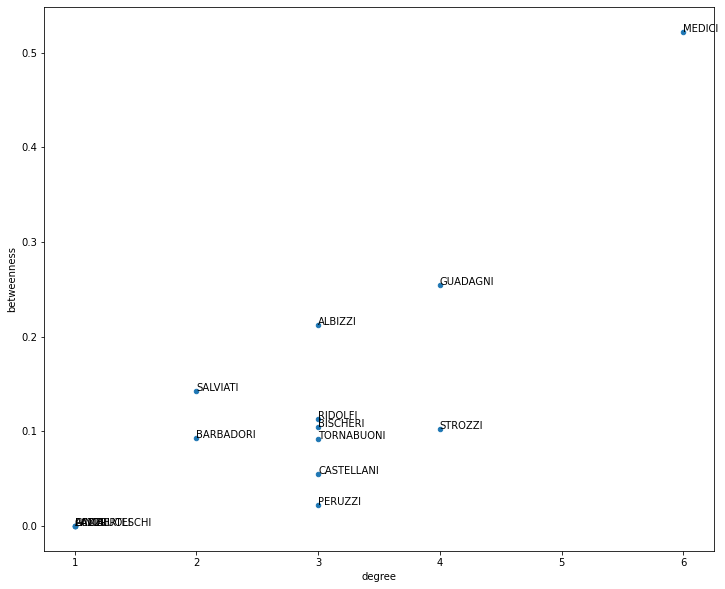

In [247]:
export[['degree','betweenness']].plot(x = 'degree', y = 'betweenness',kind='scatter',figsize=(12,10))
for i,row in list(export[['degree','betweenness']].iterrows()):
    plt.annotate(i,(row['degree'], row['betweenness']))

### Relations entre revenus et influence

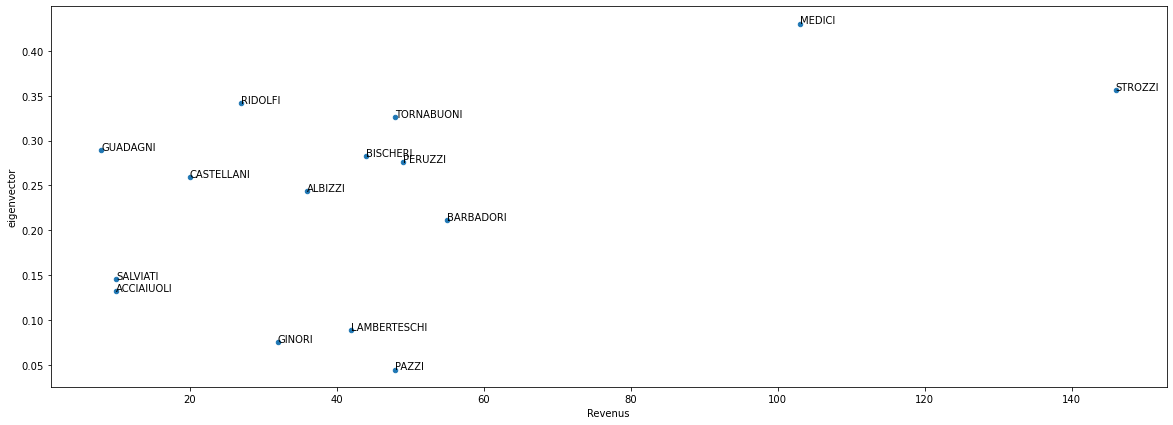

In [250]:
export[['Revenus','eigenvector']].plot(x = 'Revenus', y = 'eigenvector',kind='scatter',figsize=(20,7))
for i,row in list(export[['Revenus','eigenvector']].iterrows()):
    plt.annotate(i,(row['Revenus'], row['eigenvector']))

### Intermédiarité, revenus et sièges

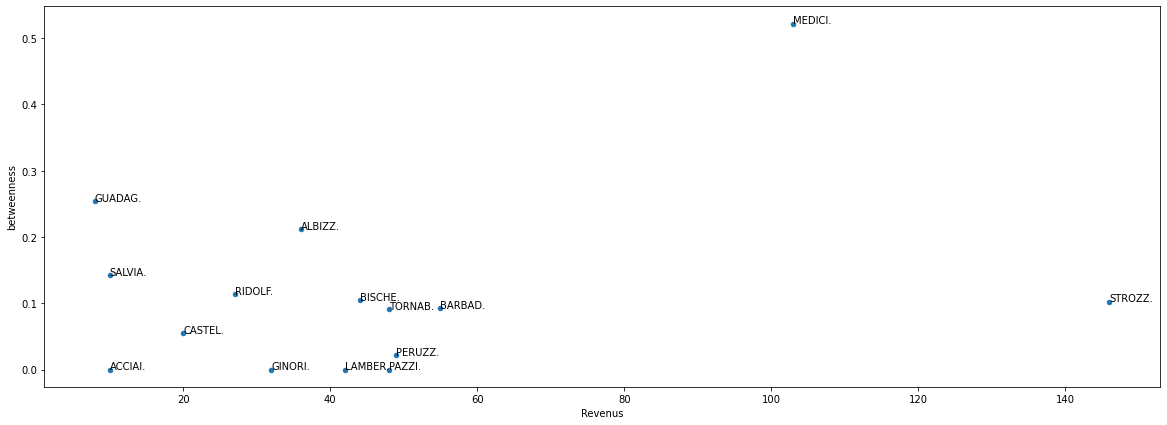

In [249]:
export[['Revenus','betweenness']].plot(x = 'Revenus', y = 'betweenness',kind='scatter',figsize=(20,7))
for i,row in list(export[['Revenus','betweenness']].iterrows()):
    plt.annotate(i[0:6]+'.',(row['Revenus'], row['betweenness']))

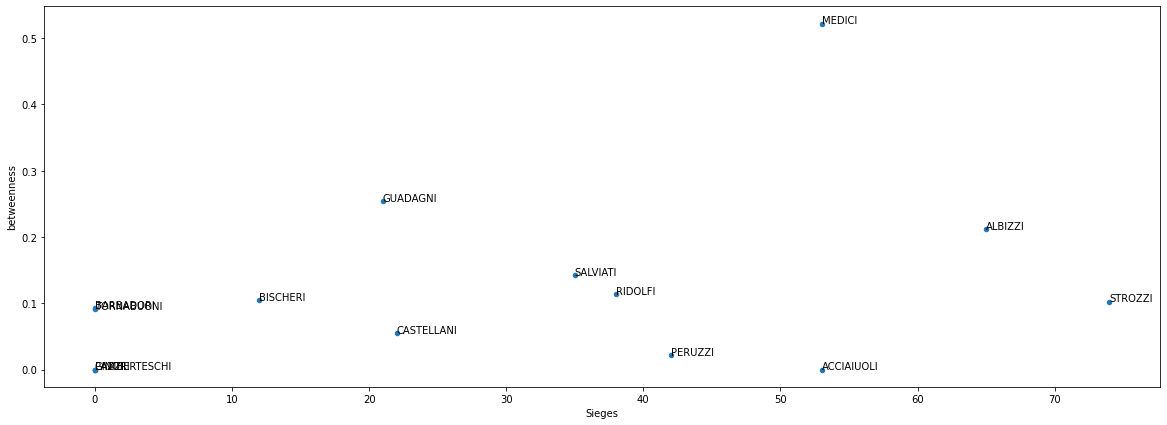

In [253]:
export[['Sieges','betweenness']].plot(x = 'Sieges', y = 'betweenness',kind='scatter',figsize=(20,7))
for i,row in list(export[['Sieges','betweenness']].iterrows()):
    plt.annotate(i,(row['Sieges'], row['betweenness']))

### Graphe : partis et intermédiarité

Le parti est représenté par la couleur des noeuds, la centralité d'intermédiarité par le diamètre du noeud.

La valuer de l'intermédiarité est artificiellement augmentée (par une multiplication et l'ajout d'une valeur minimale) afin de produire un graphe lisible.

In [254]:
node_sizes = [i[1]['betweenness'] * 800 + 10 for i in list(G.nodes.data())]
print(len(node_sizes))
node_sizes[:4]

15


[10.0, 179.96336996336996, 84.72527472527473, 93.51648351648352]

In [255]:
## effectifs par parti
l_partis = [n[1]['Parti'] for n in G.nodes.data()]
l_partis.sort()
list((k,len(list(v))) for k,v in itertools.groupby(l_partis))

[('GIR', 2), ('MED', 6), ('OLI', 7)]

In [267]:
node_colors = []
for n in G.nodes.data():
    if n[1]['Parti'] == 'GIR':
        node_colors.append(['GIR', 'DarkCyan'])
    if n[1]['Parti'] == 'MED':
        node_colors.append(['MED','Coral'])
    if n[1]['Parti'] == 'OLI':
        node_colors.append(['OLI','DeepSkyBlue'])
        
print(len(node_colors))
node_colors[:3]

15


[['MED', 'Coral'], ['OLI', 'DeepSkyBlue'], ['GIR', 'DarkCyan']]

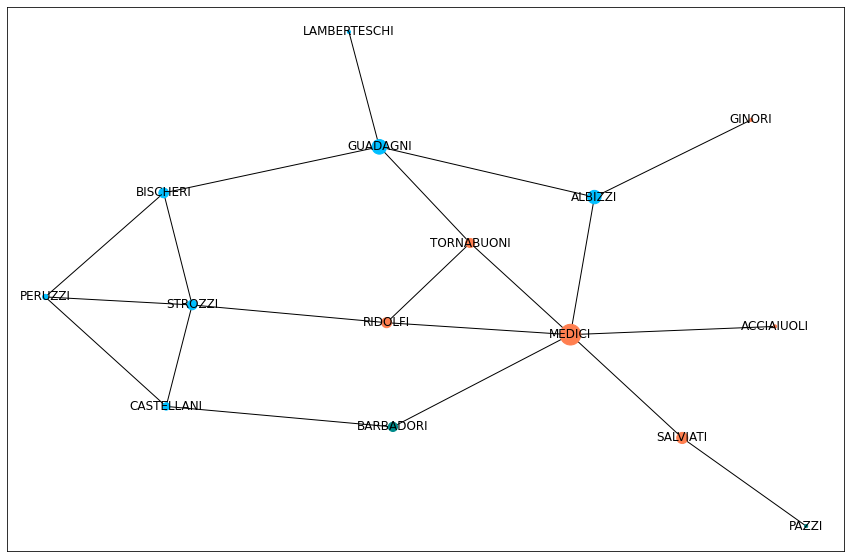

In [271]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, pos, node_color=[c[1] for c in node_colors], node_size=node_sizes)

### Relations entre nombre de sièges et influence

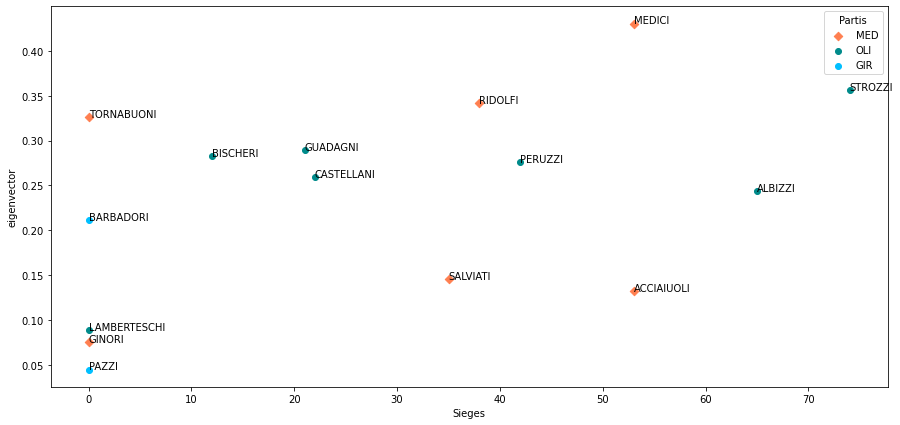

In [272]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


plt.figure(figsize=(15,7))

plt.scatter(export['Sieges'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
            export['eigenvector'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
           marker='D',
           color='Coral',
           label='MED')
plt.scatter(export['Sieges'][export.Parti == 'OLI'],
            export['eigenvector'][export.Parti == 'OLI'],
           marker='o',
           color='DarkCyan',
           label='OLI')
plt.scatter(export['Sieges'][export.Parti == 'GIR'],
            export['eigenvector'][export.Parti == 'GIR'],
           marker='o',
           color='DeepSkyBlue',
           label='GIR')
plt.xlabel('Sieges')
plt.ylabel('eigenvector')

for i,row in list(export[['Sieges','eigenvector']].iterrows()):
    plt.annotate(i,(row['Sieges'], row['eigenvector']))
plt.legend(title='Partis')
plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

### Relations entre revenu et influence

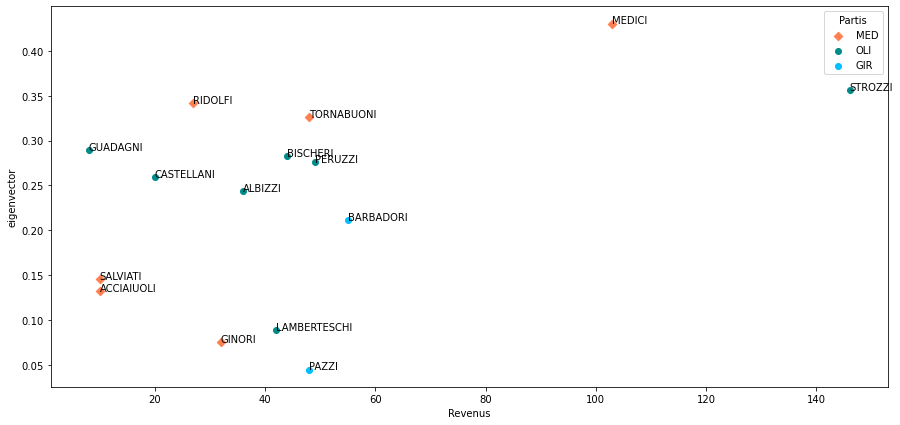

In [151]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


plt.figure(figsize=(15,7))

plt.scatter(export['Revenus'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
            export['eigenvector'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
           marker='D',
           color='Coral',
           label='MED')
plt.scatter(export['Revenus'][export.Parti == 'OLI'],
            export['eigenvector'][export.Parti == 'OLI'],
           marker='o',
           color='DarkCyan',
           label='OLI')
plt.scatter(export['Revenus'][export.Parti == 'GIR'],
            export['eigenvector'][export.Parti == 'GIR'],
           marker='o',
           color='DeepSkyBlue',
           label='GIR')
plt.xlabel('Revenus')
plt.ylabel('eigenvector')

for i,row in list(export[['Revenus','eigenvector']].iterrows()):
    plt.annotate(i,(row['Revenus'], row['eigenvector']))
plt.legend(title='Partis')
plt.savefig('plots/revenus_eigenvector_20210526.jpg')
plt.show()

### Relations entre revenu et sièges

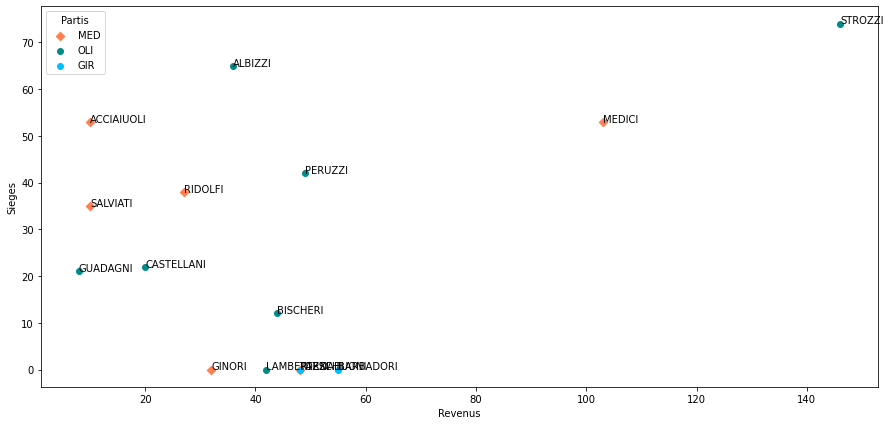

In [273]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


plt.figure(figsize=(15,7))

plt.scatter(export['Revenus'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
            export['Sieges'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
           marker='D',
           color='Coral',
           label='MED')
plt.scatter(export['Revenus'][export.Parti == 'OLI'],
            export['Sieges'][export.Parti == 'OLI'],
           marker='o',
           color='DarkCyan',
           label='OLI')
plt.scatter(export['Revenus'][export.Parti == 'GIR'],
            export['Sieges'][export.Parti == 'GIR'],
           marker='o',
           color='DeepSkyBlue',
           label='GIR')
plt.xlabel('Revenus')
plt.ylabel('Sieges')

for i,row in list(export[['Revenus','Sieges']].iterrows()):
    plt.annotate(i,(row['Revenus'], row['Sieges']))
plt.legend(title='Partis')
plt.savefig('plots/revenus_eigenvector_20210526.jpg')
plt.show()

# Cohésion et cliques

In [274]:
nx.is_connected(G), nx.density(G)

(True, 0.19047619047619047)

In [275]:
### Returns all maximal cliques in an undirected graph.
# https://networkx.org/documentation/stable/reference/algorithms/clique.html?highlight=cliques

[list(nx.find_cliques(G))]
[c for c in list(nx.find_cliques(G)) if len(c) > 2]

[['CASTELLANI', 'PERUZZI', 'STROZZI'],
 ['MEDICI', 'TORNABUONI', 'RIDOLFI'],
 ['PERUZZI', 'BISCHERI', 'STROZZI']]

In [276]:
#  https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
S = [[len(c), G.subgraph(c).copy()] for c in nx.find_cliques(G) if len(c) > 2]
# type(S)

In [277]:
a = [[s[0], s[1]] for s in S]
a

[[3, <networkx.classes.graph.Graph at 0x15b5f2d90>],
 [3, <networkx.classes.graph.Graph at 0x15b5f2f10>],
 [3, <networkx.classes.graph.Graph at 0x15b5f2290>]]

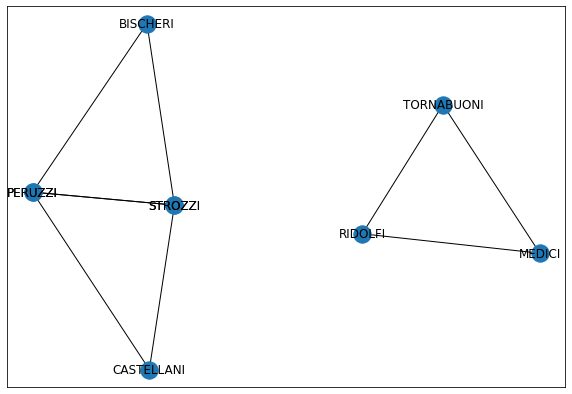

In [278]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (10,7))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

for s in S:
    nx.draw_networkx(s[1], pos)


In [281]:
### https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.kcomponents.k_components.html#networkx.algorithms.connectivity.kcomponents.k_components
nx.k_components(G)

{2: [{'ALBIZZI',
   'BARBADORI',
   'BISCHERI',
   'CASTELLANI',
   'GUADAGNI',
   'MEDICI',
   'PERUZZI',
   'RIDOLFI',
   'STROZZI',
   'TORNABUONI'}],
 1: [{'ACCIAIUOLI',
   'ALBIZZI',
   'BARBADORI',
   'BISCHERI',
   'CASTELLANI',
   'GINORI',
   'GUADAGNI',
   'LAMBERTESCHI',
   'MEDICI',
   'PAZZI',
   'PERUZZI',
   'RIDOLFI',
   'SALVIATI',
   'STROZZI',
   'TORNABUONI'}]}

In [287]:
###https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.kcomponents.k_components.html?highlight=k_components#networkx.algorithms.approximation.kcomponents.k_components

from networkx.algorithms import approximation as apxa
apxa.k_components(G, min_density = 0.9)

defaultdict(list,
            {1: [{'ACCIAIUOLI',
               'ALBIZZI',
               'BARBADORI',
               'BISCHERI',
               'CASTELLANI',
               'GINORI',
               'GUADAGNI',
               'LAMBERTESCHI',
               'MEDICI',
               'PAZZI',
               'PERUZZI',
               'RIDOLFI',
               'SALVIATI',
               'STROZZI',
               'TORNABUONI'}],
             2: [{'ALBIZZI',
               'BARBADORI',
               'BISCHERI',
               'CASTELLANI',
               'GUADAGNI',
               'MEDICI',
               'PERUZZI',
               'RIDOLFI',
               'STROZZI',
               'TORNABUONI'}]})

In [279]:
kG = nx.k_core(G, k=2)
nx.info(kG)

'Name: \nType: Graph\nNumber of nodes: 10\nNumber of edges: 15\nAverage degree:   3.0000'

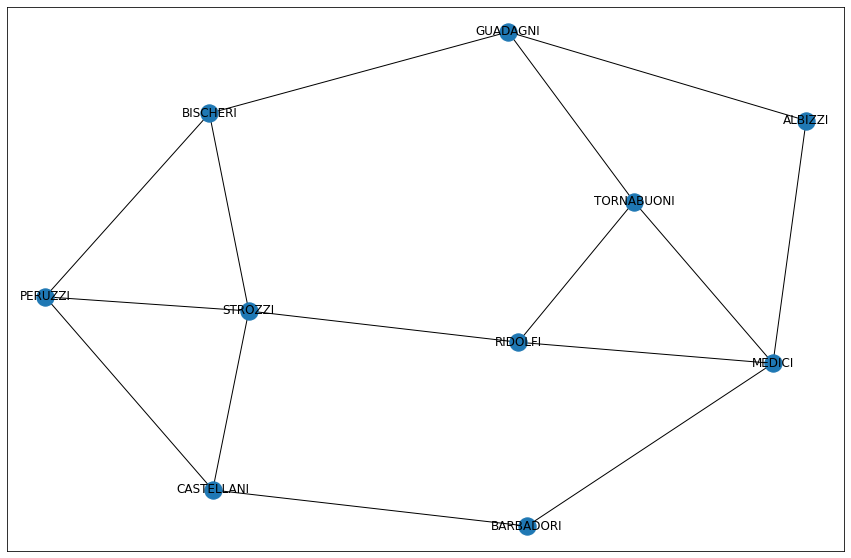

In [201]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(kG, pos)


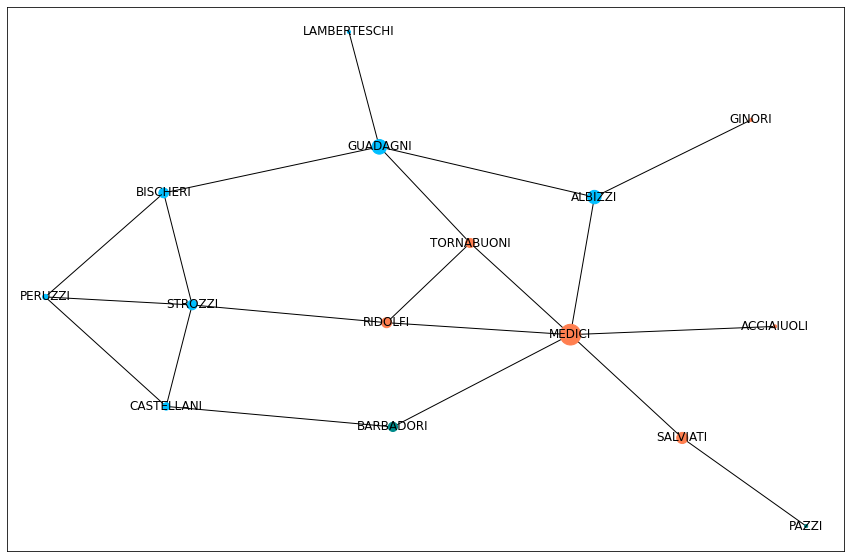

In [203]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, pos, node_color=node_colors, node_size=node_sizes)



## Bridges

In [206]:
nx.has_bridges(G), list(nx.bridges(G))

(True,
 [('ACCIAIUOLI', 'MEDICI'),
  ('ALBIZZI', 'GINORI'),
  ('GUADAGNI', 'LAMBERTESCHI'),
  ('MEDICI', 'SALVIATI'),
  ('PAZZI', 'SALVIATI')])

## Nouveau _graphe ad hoc_

In [311]:
PKB = nx.read_pajek('data/cellier_cocaud_chap_11-15/florence_bridges.net')
print(nx.info(PKB))

Name: 
Type: MultiGraph
Number of nodes: 35
Number of edges: 42
Average degree:   2.4000


In [294]:
### Y a-t-il des loops ? Un sommet en relation avec lui même ?
# https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.nodes_with_selfloops.html
list(nx.nodes_with_selfloops(PKB))

[]

In [297]:
### Nettoyer le graphe original (format Pajek .net)

GB = nx.Graph(PKB)
e = GB.nodes()
pop = [GB.nodes[n].pop('id',None) for n in e]
print(GB.nodes.data())

[('ACCIAIUOLI', {}), ('ALBIZZI', {}), ('BARBADORI', {}), ('BISCHERI', {}), ('CASTELLANI', {}), ('GINORI', {}), ('GUADAGNI', {}), ('LAMBERTESCHI', {}), ('MEDICI', {}), ('PAZZI', {}), ('PERUZZI', {}), ('RIDOLFI', {}), ('SALVIATI', {}), ('STROZZI', {}), ('TORNABUONI', {}), ('D1', {}), ('D2', {}), ('D3', {}), ('D4', {}), ('D5', {}), ('ACCIAIUOLI_2', {}), ('ALBIZZI_2', {}), ('BARBADORI_2', {}), ('BISCHERI_2', {}), ('CASTELLANI_2', {}), ('GINORI_2', {}), ('GUADAGNI_2', {}), ('LAMBERTESCHI_2', {}), ('MEDICI_2', {}), ('PAZZI_2', {}), ('PERUZZI_2', {}), ('RIDOLFI_2', {}), ('SALVIATI_2', {}), ('STROZZI_2', {}), ('TORNABUONI_2', {})]


In [313]:
### Principales caractéristiques de ce graphe

GB.is_multigraph(), GB.is_directed(), GB.number_of_nodes(), GB.number_of_edges(), nx.is_connected(GB), nx.density(GB)

(False, False, 35, 42, False, 0.07058823529411765)

In [314]:
nx.number_connected_components(GB)

6

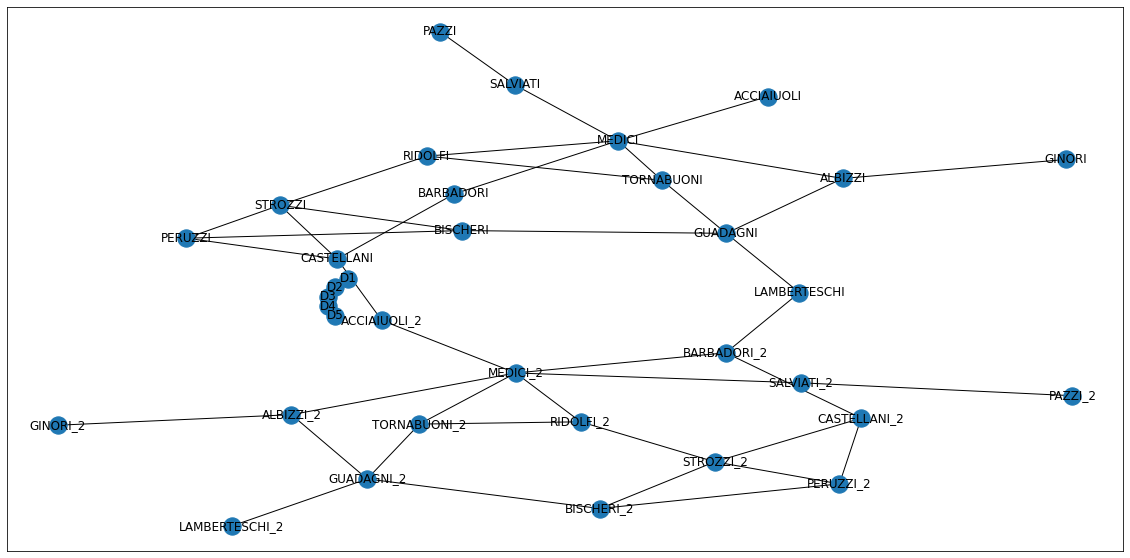

In [298]:
### Un premier affichage (ne marche que avec peu de sommets)

# l'algorithme cherche la meilleure position des somments
# si on exécute plurieurs fois l'apparence peut changer
pos = nx.kamada_kawai_layout(GB)
plt.figure(figsize = (20,10))
nx.draw_networkx(GB, pos)

In [303]:
## Centralité et dispersion du degré
df_degree = pd.DataFrame(list(nx.degree(GB)), columns = ['famille', 'degree'])
df_degree.head()
df_degree.set_index(['famille'],inplace=True)
df_degree.head()

,degree
famille,
ACCIAIUOLI,1
ALBIZZI,3
BARBADORI,2
BISCHERI,3
CASTELLANI,4


In [304]:
df_degree['degree'].describe()

count    35
mean      2
std       2
min       0
25%       1
50%       3
75%       3
max       6
Name: degree, dtype: float64

In [315]:
list(df_degree[df_degree['degree']== 0].index)

['D1', 'D2', 'D3', 'D4', 'D5']

### Graphe avec sommets de degré plus grand que 0 (dans l'original)

In [332]:
#  https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
SG0 = GB.subgraph(list(df_degree[df_degree['degree'] > 0].index)).copy()
nx.number_connected_components(SG0)

1

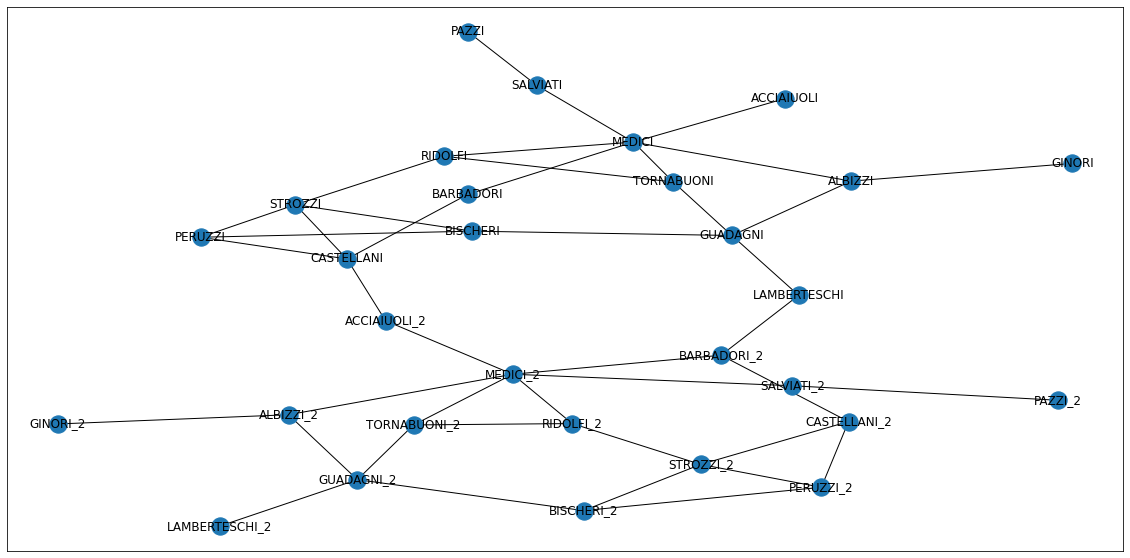

In [334]:
### Un premier affichage (ne marche que avec peu de sommets)

# l'algorithme cherche la meilleure position des somments
# si on exécute plurieurs fois l'apparence peut changer
pos = nx.kamada_kawai_layout(SG0)
plt.figure(figsize = (20,10))
nx.draw_networkx(SG0, pos)

### Graphe avec sommets de degré plus grand que 2 (dans l'original)

In [335]:
#  https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
SG2 = GB.subgraph(list(df_degree[df_degree['degree'] > 2].index)).copy()
nx.number_connected_components(SG2)

2

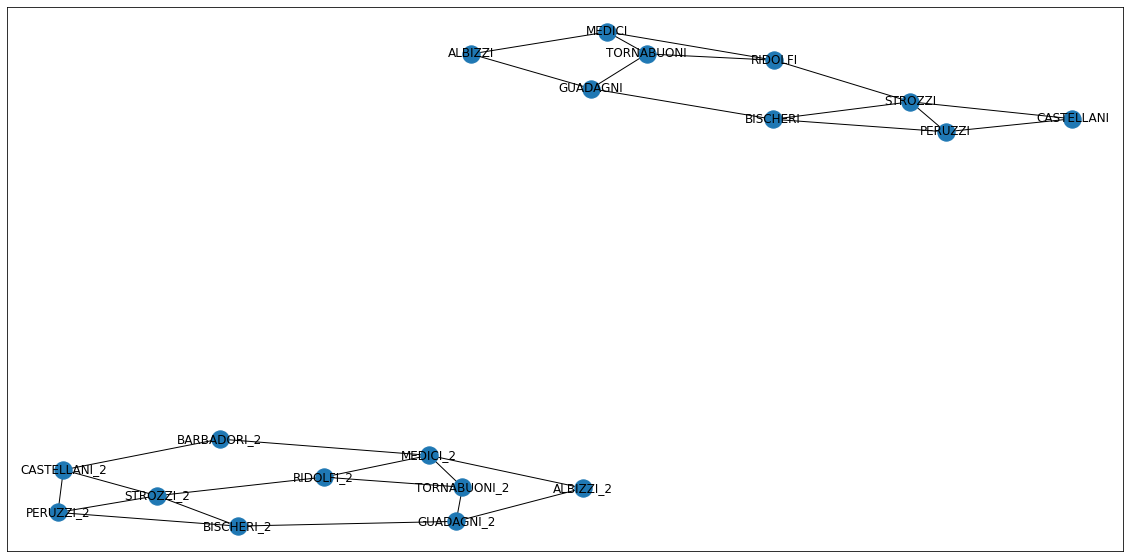

In [338]:
### Un premier affichage (ne marche que avec peu de sommets)

plt.figure(figsize = (20,10))
nx.draw_networkx(SG2)

## Ajouter les paramètres de centralité

### Centralité de degré

In [350]:
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(SG0)])
nx.set_node_attributes(SG0, degree)
# print(SG0.nodes.data())

### Centralité de proximité

In [351]:
closeness = nx.closeness_centrality(SG0)
nx.set_node_attributes(SG0, closeness, 'closeness')

### Centralité d'intermédiarité

In [375]:
betweenness = nx.betweenness_centrality(SG0)
nx.set_node_attributes(SG0, betweenness, 'betweenness')

pd.Series(betweenness.values()).describe()


count    30.0000
mean      0.1011
std       0.1139
min       0.0000
25%       0.0176
50%       0.0616
75%       0.1315
max       0.4696
dtype: float64

### Centralité d'influence ou de pouvoir (_eigenvalue_)

In [355]:
## Ne marche pas, trop d'iterations nécessaires, vrais. vu la structure du graphe
# à vérifier
# eigenvector = nx.eigenvector_centrality(SG0, max_iter= 90)
# nx.set_node_attributes(SG0, eigenvector, 'eigenvector')

## Tableau résultat

In [356]:
print(list(SG0.nodes.data())[:5])

[('ACCIAIUOLI', {'degree': 1, 'closeness': 0.21804511278195488, 'betweenness': 0.0}), ('ALBIZZI', {'degree': 3, 'closeness': 0.2761904761904762, 'betweenness': 0.10544217687074829}), ('BARBADORI', {'degree': 2, 'closeness': 0.29, 'betweenness': 0.13312221440300256}), ('BISCHERI', {'degree': 3, 'closeness': 0.2636363636363636, 'betweenness': 0.03078817733990148}), ('CASTELLANI', {'degree': 4, 'closeness': 0.3258426966292135, 'betweenness': 0.27622566267886456})]


## Exporter les attributs pour les explorer 

In [357]:
### Exporter les attributs vers un DataFrame afin de les explorer
export_SG0 = pd.DataFrame(SG0.nodes.data(), columns = ['id', 'attributes'])
pd.json_normalize(export_SG0.attributes)
export_SG0 = export_SG0.join(pd.json_normalize(export_SG0.attributes)).set_index('id')
export_SG0.drop(columns=['attributes'], inplace=True)

pd.options.display.float_format = '{: .04f}'.format
export_SG0.sort_values(by=['betweenness'], ascending=False)

,degree,closeness,betweenness
id,,,
MEDICI_2,6,0.3537,0.4696
CASTELLANI,4,0.3258,0.2762
ACCIAIUOLI_2,2,0.3333,0.2680
BARBADORI_2,3,0.3333,0.2570
GUADAGNI,4,0.3152,0.2373
MEDICI,6,0.2762,0.2340
LAMBERTESCHI,2,0.3222,0.2164
BARBADORI,2,0.2900,0.1331
ALBIZZI_2,3,0.2871,0.1267


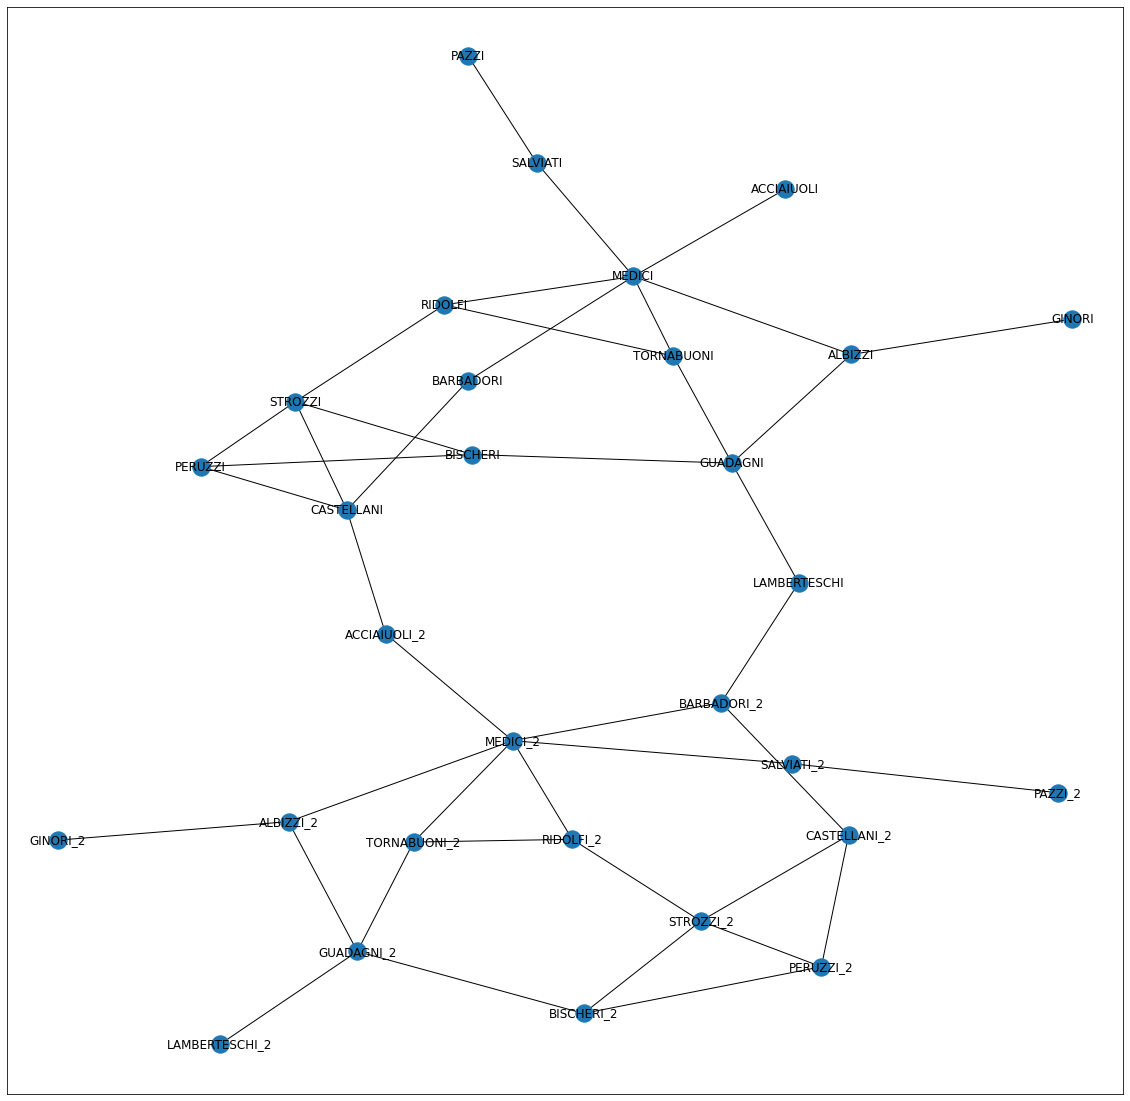

In [360]:
### Un premier affichage (ne marche que avec peu de sommets)

# l'algorithme cherche la meilleure position des somments
# si on exécute plurieurs fois l'apparence peut changer
pos = nx.kamada_kawai_layout(SG0)
plt.figure(figsize = (20,20))
nx.draw_networkx(SG0, pos)

## Explorer les relations entre propriétés structurales (centralités) et/ou attributs

### Relations entre deux centralités

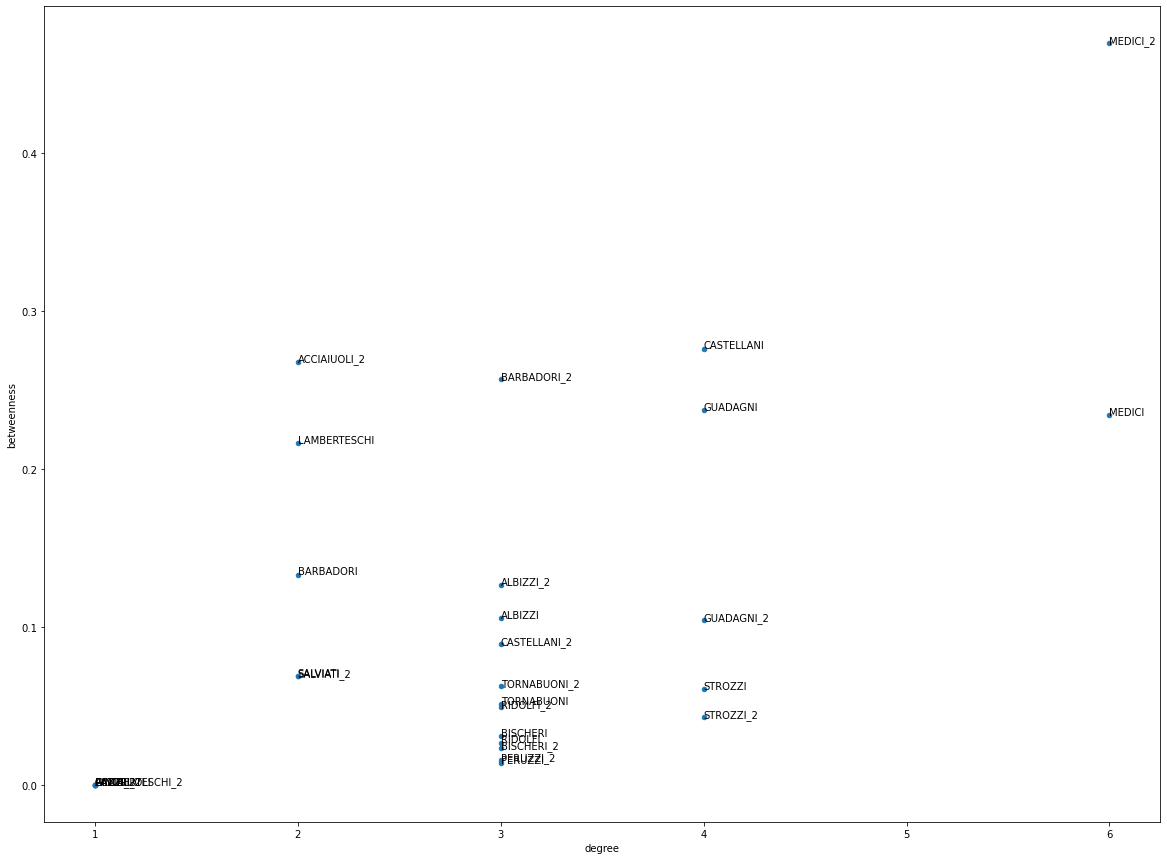

In [363]:
export_SG0[['degree','betweenness']].plot(x = 'degree', y = 'betweenness',kind='scatter',figsize=(20,15))
for i,row in list(export_SG0[['degree','betweenness']].iterrows()):
    plt.annotate(i,(row['degree'], row['betweenness']))

# Cohésion et cliques

In [376]:
nx.is_connected(SG0), nx.density(SG0)

(True, 0.09655172413793103)

In [394]:
### Returns all maximal cliques in an undirected graph.
# https://networkx.org/documentation/stable/reference/algorithms/clique.html?highlight=cliques

[list(nx.find_cliques(SG0))]

[[['CASTELLANI', 'PERUZZI', 'STROZZI'],
  ['CASTELLANI', 'BARBADORI'],
  ['CASTELLANI', 'ACCIAIUOLI_2'],
  ['PAZZI', 'SALVIATI'],
  ['TORNABUONI', 'RIDOLFI', 'MEDICI'],
  ['TORNABUONI', 'GUADAGNI'],
  ['LAMBERTESCHI', 'GUADAGNI'],
  ['LAMBERTESCHI', 'BARBADORI_2'],
  ['GUADAGNI', 'ALBIZZI'],
  ['GUADAGNI', 'BISCHERI'],
  ['BISCHERI', 'PERUZZI', 'STROZZI'],
  ['BISCHERI_2', 'PERUZZI_2', 'STROZZI_2'],
  ['BISCHERI_2', 'GUADAGNI_2'],
  ['BARBADORI', 'MEDICI'],
  ['LAMBERTESCHI_2', 'GUADAGNI_2'],
  ['MEDICI_2', 'SALVIATI_2'],
  ['MEDICI_2', 'ACCIAIUOLI_2'],
  ['MEDICI_2', 'TORNABUONI_2', 'RIDOLFI_2'],
  ['MEDICI_2', 'ALBIZZI_2'],
  ['MEDICI_2', 'BARBADORI_2'],
  ['PERUZZI_2', 'STROZZI_2', 'CASTELLANI_2'],
  ['ACCIAIUOLI', 'MEDICI'],
  ['RIDOLFI', 'STROZZI'],
  ['GUADAGNI_2', 'TORNABUONI_2'],
  ['GUADAGNI_2', 'ALBIZZI_2'],
  ['GINORI_2', 'ALBIZZI_2'],
  ['GINORI', 'ALBIZZI'],
  ['SALVIATI', 'MEDICI'],
  ['PAZZI_2', 'SALVIATI_2'],
  ['ALBIZZI', 'MEDICI'],
  ['STROZZI_2', 'RIDOLFI_2'],
  ['CA

In [395]:
[c for c in list(nx.find_cliques(SG0)) if len(c) > 2]

[['CASTELLANI', 'PERUZZI', 'STROZZI'],
 ['TORNABUONI', 'RIDOLFI', 'MEDICI'],
 ['BISCHERI', 'PERUZZI', 'STROZZI'],
 ['BISCHERI_2', 'PERUZZI_2', 'STROZZI_2'],
 ['MEDICI_2', 'TORNABUONI_2', 'RIDOLFI_2'],
 ['PERUZZI_2', 'STROZZI_2', 'CASTELLANI_2']]

In [ ]:
### https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.kcomponents.k_components.html#networkx.algorithms.connectivity.kcomponents.k_components
nx.k_components(SG0)

In [383]:
###https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.kcomponents.k_components.html?highlight=k_components#networkx.algorithms.approximation.kcomponents.k_components

from networkx.algorithms import approximation as apxa
apxa.k_components(SG0, min_density = 0.1)

defaultdict(list,
            {1: [{'ACCIAIUOLI',
               'ACCIAIUOLI_2',
               'ALBIZZI',
               'ALBIZZI_2',
               'BARBADORI',
               'BARBADORI_2',
               'BISCHERI',
               'BISCHERI_2',
               'CASTELLANI',
               'CASTELLANI_2',
               'GINORI',
               'GINORI_2',
               'GUADAGNI',
               'GUADAGNI_2',
               'LAMBERTESCHI',
               'LAMBERTESCHI_2',
               'MEDICI',
               'MEDICI_2',
               'PAZZI',
               'PAZZI_2',
               'PERUZZI',
               'PERUZZI_2',
               'RIDOLFI',
               'RIDOLFI_2',
               'SALVIATI',
               'SALVIATI_2',
               'STROZZI',
               'STROZZI_2',
               'TORNABUONI',
               'TORNABUONI_2'}],
             2: [{'ACCIAIUOLI_2',
               'ALBIZZI',
               'ALBIZZI_2',
               'BARBADORI',
               'BARBA

In [390]:
kG = nx.k_core(SG0, k=2)
nx.info(kG)

'Name: \nType: Graph\nNumber of nodes: 22\nNumber of edges: 34\nAverage degree:   3.0909'

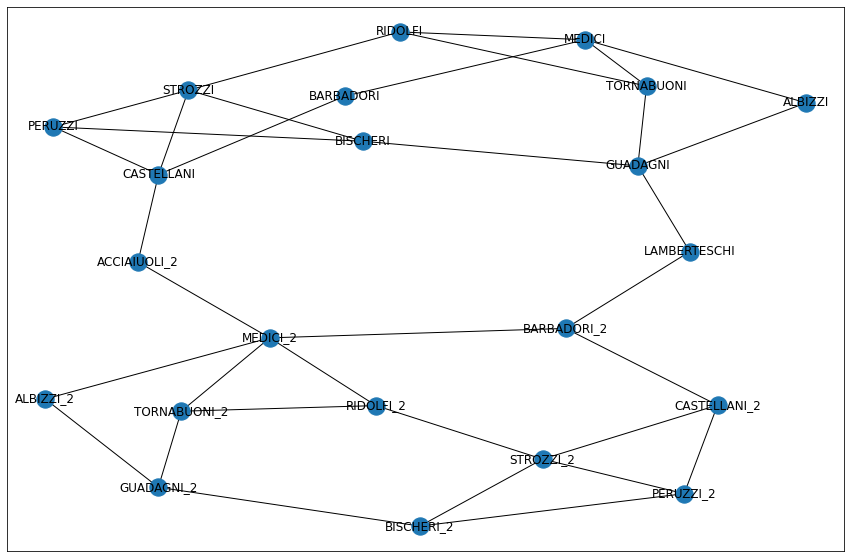

In [387]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(kG)

nx.draw_networkx(kG, pos)
